In [125]:
# %load /Users/wayment/ipynb_defaults.py
%pylab inline
import numpy as np
import pandas as pd

import seaborn as sns
sns.set_style('ticks')
sns.set_context('paper')
import sys,os

sys.path.append('../../scripts/')
from utils import load_fasta,write_fasta
import logomaker
from scipy.stats import ttest_ind

%pylab is deprecated, use %matplotlib inline and import the required libraries.
Populating the interactive namespace from numpy and matplotlib


/Users/wayment/opt/miniconda3/lib/python3.8/site-packages/IPython/core/magics/pylab.py:162: UserWarning: pylab import has clobbered these variables: ['get_state']
`%matplotlib` prevents importing * from pylab and numpy
  warn("pylab import has clobbered these variables: %s"  % clobbered +


In [126]:
df = pd.read_json('feats_kaibrs_WT_05apr2023.json.zip')

df['cluster_ind'] = [os.path.basename(x.replace('.pdb','')).split('_')[-1] for x in df['pdb']]
df['pdb'] = [x.replace('KaiBRS_AFcluster_preds/','') for x in df['pdb']]
def get_type(pdb):
    end = pdb.split('_')[-1]
    if end=='REF.pdb':
        return 'REF'
    elif end.startswith('U'):
        return end.split('-')[0]
    else:
        return 'Tree'
    
df['Type'] = df.apply(lambda row: get_type(row['pdb']), axis=1)

def get_state(string):
    if 'H' in string[-10:] and 'E' in string[-20:-10]:
        return 'FS'
    elif 'EEE' in string[-10:]:
        return 'Ground'
    else:
        return 'Other'
    
df['state'] = df.apply(lambda row: get_state(row['dssp_string']), axis=1)

In [8]:
df.head()

,pdb,pLDDT_vector,mean_pLDDT,dssp_string,cluster_ind,Type,state
0,KAIBRS_000_1.pdb,"[35.71, 41.05, 49.9, 55.09, 67.51, 72.1, 78.15...",71.641196,CCCCEEEEEEECCCCHHHHHHHHHHHHHHHHHCCCCEEEEEEECCC...,1,Tree,FS
1,KAIBRS_001_1.pdb,"[32.12, 40.05, 47.97, 54.56, 64.5, 68.24, 69.5...",61.730217,CCCCEEEEEEECCCCHHHHHHHHHHHHHHHHHCCCCEEEEEEECCC...,1,Tree,Ground
2,KAIBRS_002_1.pdb,"[32.14, 36.16, 49.14, 54.25, 63.72, 64.72, 68....",65.108696,CCCCEEEEEEECCCCHHHHHHHHHHHHHHHHHCCCCEEEEEEECCC...,1,Tree,Other
3,KAIBRS_003_1.pdb,"[36.44, 47.51, 57.59, 66.23, 76.77, 86.26, 89....",84.132717,CCCCEEEEEEECCCCHHHHHHHHHHHHHHHHHCCCCEEEEEEECCC...,1,Tree,FS
4,KAIBRS_004_1.pdb,"[32.9, 41.19, 50.77, 55.41, 64.68, 69.11, 72.1...",64.507609,CCCCEEEEEEECCCCHHHHHHHHHHHHHHHHHCCCCEEEEEEECCC...,1,Tree,FS


<AxesSubplot:xlabel='state', ylabel='mean_pLDDT'>

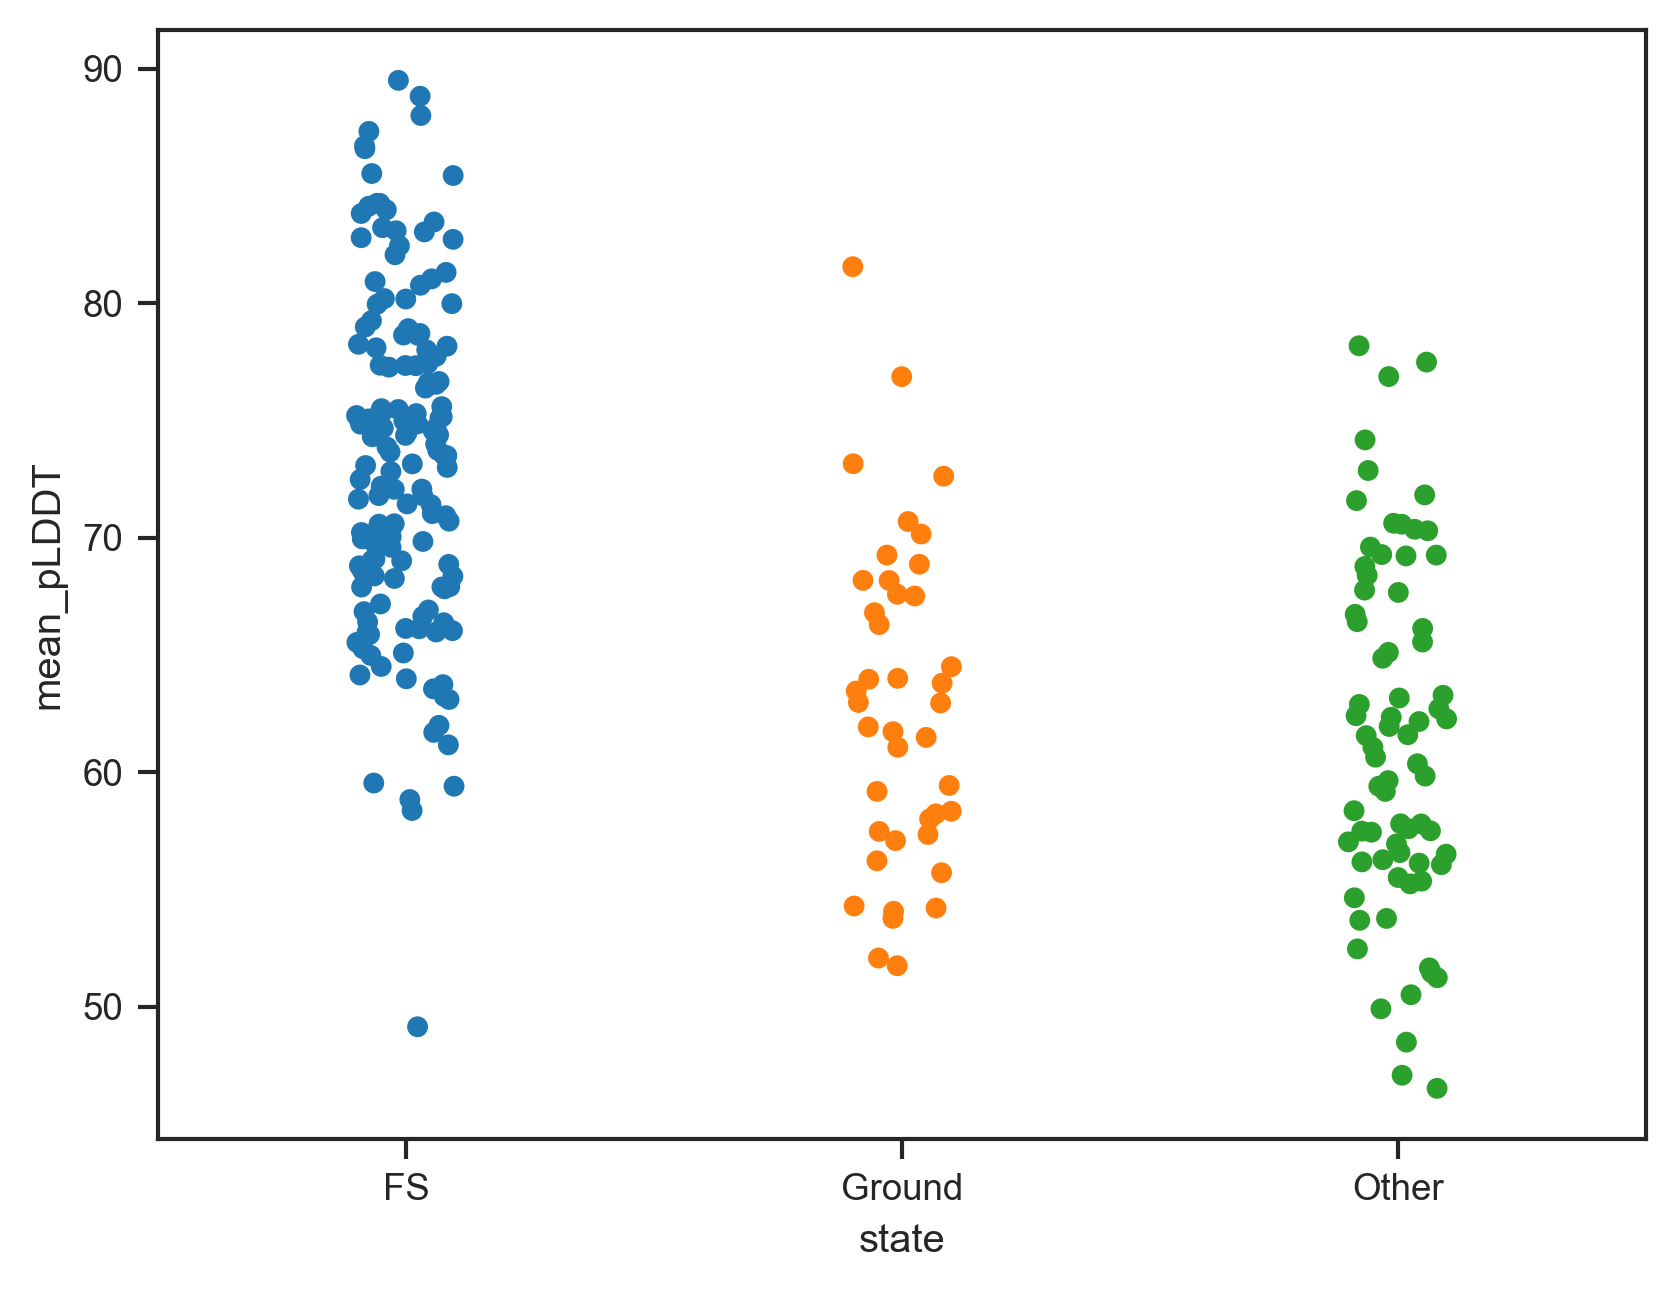

In [10]:
sns.stripplot(x='state',y='mean_pLDDT',data=df)

In [132]:
# load sequences from MSAs for those states

def load_single_seq(pdb):
    msa_path = 'KaiBRS_msas_for_AFcluster/'+pdb.replace('_1.pdb','.a3m')
    names, seqs = load_fasta(msa_path)
    return [np.random.choice(seqs[1:])]


def load_seqs(pdb):
    msa_path = 'KaiBRS_msas_for_AFcluster/'+pdb.replace('_1.pdb','.a3m')
    names, seqs = load_fasta(msa_path)
    return seqs


ex_ground_clusters = df.loc[df.state=='Ground'].loc[df.Type=='Tree'] #.loc[df.mean_pLDDT>65]
ex_fs_clusters =  df.loc[df.state=='FS'].loc[df.Type=='Tree'] #.loc[df.mean_pLDDT>65]

print(len(ex_ground_clusters))
print(len(ex_fs_clusters))

tmp = [load_single_seq(x) for x in ex_ground_clusters['pdb'].sample(n=10000,replace=True)]
ground_seqs = [inner for outer in tmp for inner in outer] 

tmp = [load_single_seq(x) for x in ex_fs_clusters['pdb'].sample(n=10000,replace=True)]
fs_seqs = [inner for outer in tmp for inner in outer] 

kaibrs_seq='GAMGRRLVLYVAGQTPKSLAAISNLRRICEENLPGQYEVEVIDLKQNPRLAKEHSIVAIPTLVRELPVPIRKIIGDLSDKEQVLVNLKMDME'
######       0000000000111111111122222222223333333333444444444455555555556666666666777777777788888888889
# numbering  0123456789012345678901234567890123456789012345678901234567890123456789012345678901234567890

gs_pssm = logomaker.alignment_to_matrix(ground_seqs, to_type='probability',characters_to_ignore='X-')
fs_pssm = logomaker.alignment_to_matrix(fs_seqs,to_type='probability',characters_to_ignore='X-')

41
155


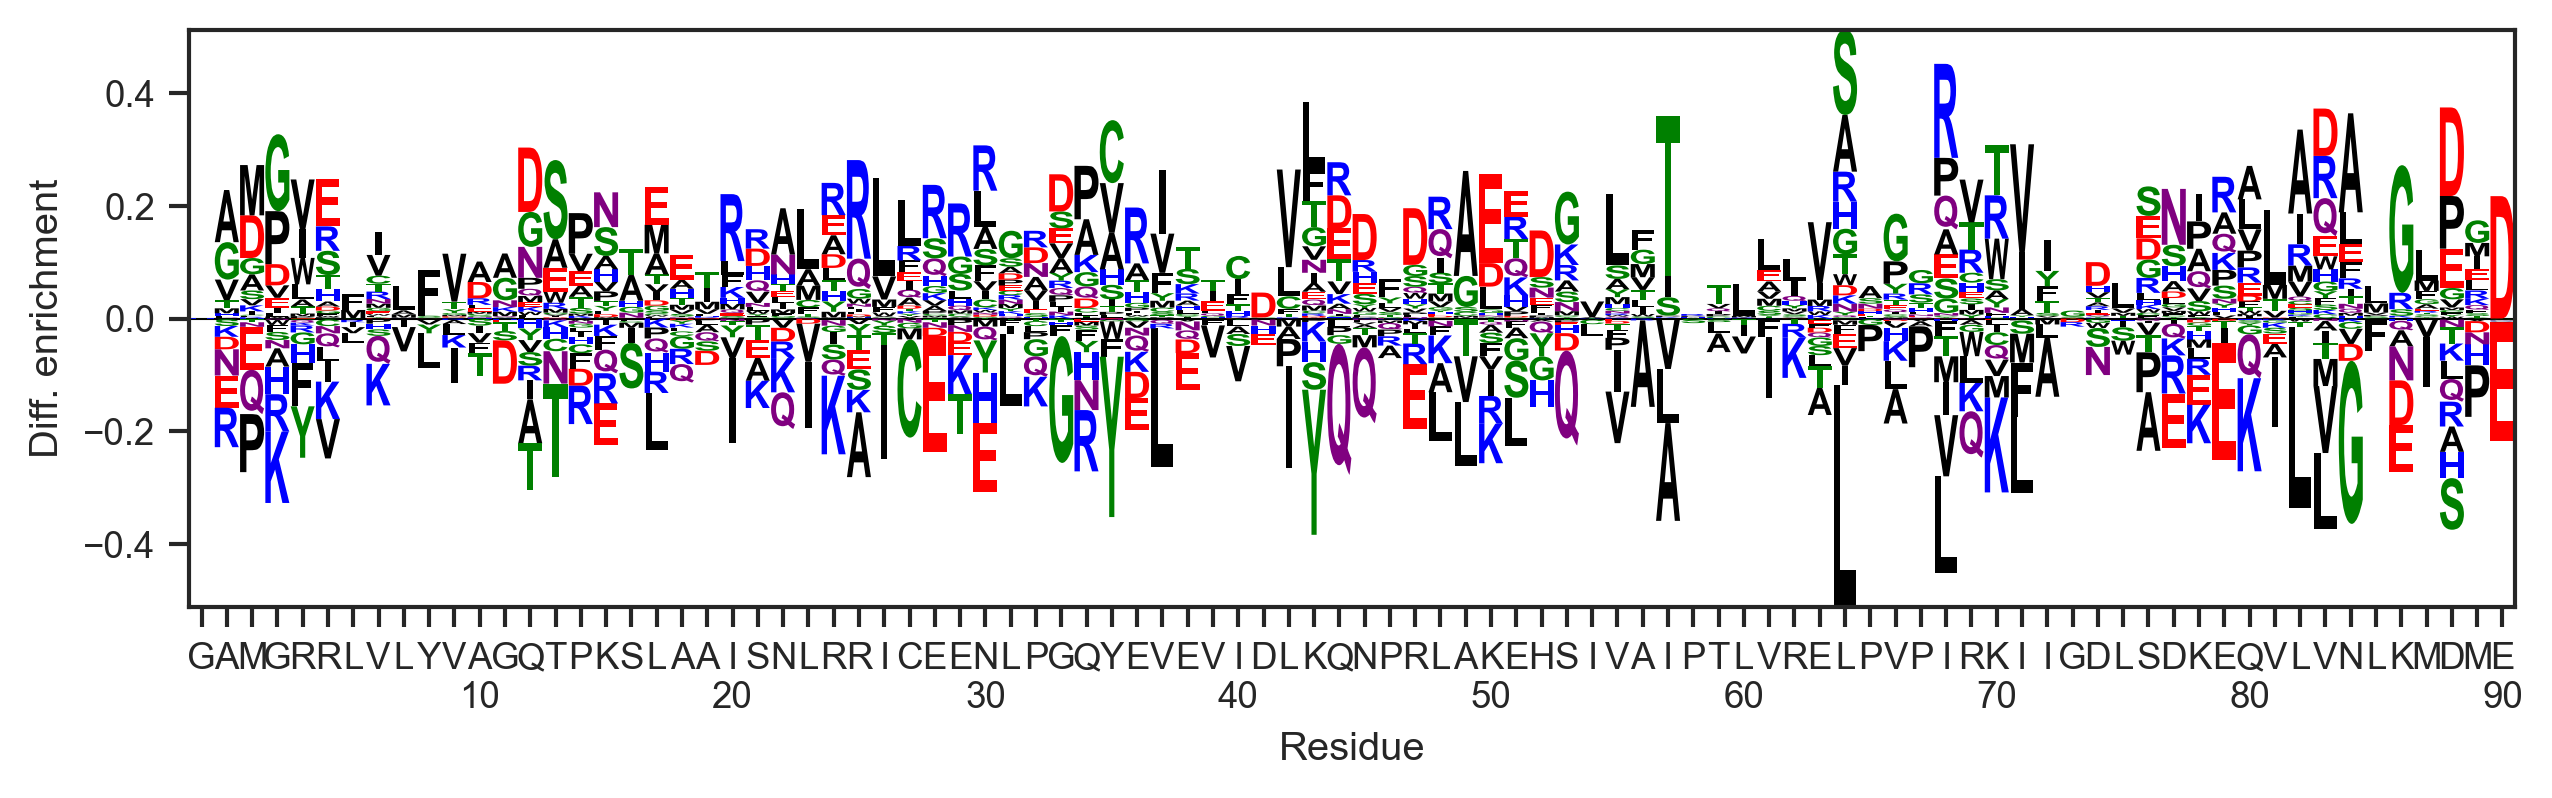

In [145]:
diff = np.subtract(fs_pssm,gs_pssm)

logomaker.Logo(diff,color_scheme='chemistry',flip_below=False)

labels=[]
for i, char in enumerate(kaibrs_seq):
    if (i-1)%10==0 and i!=1:
        labels.append('%s\n%d' % (char, i-1))
    else:
        labels.append(char)
xticks(range(len(kaibrs_seq)), labels)

#xlim([53.5,91])
xlabel('Residue')
ylabel('Diff. enrichment')

savefig('KaiBRS_diff_enrichment_07apr2023.pdf',bbox_inches='tight')

In [134]:
diff = diff.reset_index()
diff['sum'] = diff.apply(lambda row: np.sum([np.abs(row[x]) for x in list('ACDEFGHIKLMNPQRSTVWY')]), axis=1)

# mut_df = diff.melt(id_vars=['pos','sum'],var_name='mut')
# mut_df = mut_df.loc[mut_df.value>0]
# max_likelihood = mut_df.groupby('pos').transform('max')

In [135]:
n_muts=10
top_muts = [(x-1) for x in diff.sort_values('sum',ascending=False)[:n_muts]['pos']]

print(top_muts)
new_aas = []
muts_to_use=[]
mut_strings=[]
for x in top_muts:
    row = diff.loc[diff.pos==x+1].iloc[0]
    
    top_ = np.argmax([row[x] for x in list('ACDEFGHIKLMNPQRSTVWY')])
    old_aa = kaibrs_seq[x+1]
    new_aa = list('ACDEFGHIKLMNPQRSTVWY')[top_]
    
    if old_aa != new_aa:
        ms = "%s%d%s" % (old_aa, x, new_aa)
        mut_strings.append(ms)
        muts_to_use.append(x)
        new_aas.append(new_aa)

[64, 68, 43, 88, 83, 84, 57, 35, 82, 2]


In [136]:
mut_strings

['L64S', 'I68R', 'K43L', 'V83D', 'N84A', 'I57T', 'Y35C', 'L82A']

In [138]:
from itertools import combinations

for i in range(1,6):
    for set_of_muts in combinations(muts_to_use,i):
        seq = copy(list(WT_seq))
        mss=[]
        for j, mut in enumerate(set_of_muts):
            seq[mut+1] = new_aas[muts_to_use.index(mut)]
            mss.append(mut_strings[muts_to_use.index(mut)])
            
        name='_'.join(mss)
        with open('indiv_fastas_apr7/%s.fasta' % name,'w') as f:
            f.write(">%s\n%s\n" % (name, ''.join(seq)))
            print('>'+name)
            print(''.join(seq))

>L64S
GAMGRRLVLYVAGQTPKSLAAISNLRRICEENLPGQYEVEVIDLKQNPRLAKEHSIVAIPTLVRESPVPIRKIIGDLSDKEQVLVNLKMDME
>I68R
GAMGRRLVLYVAGQTPKSLAAISNLRRICEENLPGQYEVEVIDLKQNPRLAKEHSIVAIPTLVRELPVPRRKIIGDLSDKEQVLVNLKMDME
>K43L
GAMGRRLVLYVAGQTPKSLAAISNLRRICEENLPGQYEVEVIDLLQNPRLAKEHSIVAIPTLVRELPVPIRKIIGDLSDKEQVLVNLKMDME
>V83D
GAMGRRLVLYVAGQTPKSLAAISNLRRICEENLPGQYEVEVIDLKQNPRLAKEHSIVAIPTLVRELPVPIRKIIGDLSDKEQVLDNLKMDME
>N84A
GAMGRRLVLYVAGQTPKSLAAISNLRRICEENLPGQYEVEVIDLKQNPRLAKEHSIVAIPTLVRELPVPIRKIIGDLSDKEQVLVALKMDME
>I57T
GAMGRRLVLYVAGQTPKSLAAISNLRRICEENLPGQYEVEVIDLKQNPRLAKEHSIVATPTLVRELPVPIRKIIGDLSDKEQVLVNLKMDME
>Y35C
GAMGRRLVLYVAGQTPKSLAAISNLRRICEENLPGQCEVEVIDLKQNPRLAKEHSIVAIPTLVRELPVPIRKIIGDLSDKEQVLVNLKMDME
>L82A
GAMGRRLVLYVAGQTPKSLAAISNLRRICEENLPGQYEVEVIDLKQNPRLAKEHSIVAIPTLVRELPVPIRKIIGDLSDKEQVAVNLKMDME
>L64S_I68R
GAMGRRLVLYVAGQTPKSLAAISNLRRICEENLPGQYEVEVIDLKQNPRLAKEHSIVAIPTLVRESPVPRRKIIGDLSDKEQVLVNLKMDME
>L64S_K43L
GAMGRRLVLYVAGQTPKSLAAISNLRRICEENLPGQYEVEVIDLLQNPRLAKEHSIVAIPTLVRESPVPIRKIIGDLSDKEQVLVNLKMDME
